2018.01.16

In [16]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from pygeocoder import Geocoder
from mpl_toolkits.basemap import Basemap

%matplotlib inline

## Import the csv

In [17]:
# where this data came from: https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp?pn=1
orig_data = pd.read_csv('./project_datasets/682464398_102017_1651_airline_delay_causes.csv', skipinitialspace=True)

## Clean the data

### drop the extraneous column that has no information

In [18]:
data_right_columns = orig_data.drop('Unnamed: 21', axis=1)

Some of the column names have initial space, so we use a regular expression  

to make them easier to work with programmatically

In [19]:
columns = []
for i, col in enumerate(data_right_columns.columns):
    global columns
    col = re.sub(r'\s+', '', col)
    columns.append(col)
data_right_columns.columns = columns
data_right_columns.columns

Index([u'year', u'month', u'carrier', u'carrier_name', u'airport',
       u'airport_name', u'arr_flights', u'arr_del15', u'carrier_ct',
       u'weather_ct', u'nas_ct', u'security_ct', u'late_aircraft_ct',
       u'arr_cancelled', u'arr_diverted', u'arr_delay', u'carrier_delay',
       u'weather_delay', u'nas_delay', u'security_delay',
       u'late_aircraft_delay'],
      dtype='object')

### Dropping the NaN rows as invalid data, it is a small percentage of the entire dataset

In [20]:
data_right_columns.shape

(11193, 21)

In [21]:
data_NoNaN = data_right_columns.dropna(axis=0)

So, the Nans have been dropped...

### We wil now use the first variable, `data_NoNaN` and set it to `data` ...

The next four strategies of NaN handling are commented out, but also will be `data`

In [22]:
data = data_NoNaN

Looking at the shape of our data, the 18 dropped values, give us 11173 observations and 21 features

In [23]:
data.shape

(11173, 21)

# Target
We have determined that the goal of this data analysis is to predict delayed flights, given certain conditions based on the dataset.  Therefore the target variable is `arr_del15`




Let's make the target variable binary.

In [25]:
data['target'] = [1 if targ >= 15.0 else 0 for targ in data.arr_del15]
data['target'].value_counts()

/Users/jg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


1    6651
0    4522
Name: target, dtype: int64

#### Now that `target_x` has been created and added to the dataframe, `data`, `arr_del15` needs to be dropped since it is now redundant

In [26]:
data = data.drop('arr_del15', axis=1)
data.columns

Index([u'year', u'month', u'carrier', u'carrier_name', u'airport',
       u'airport_name', u'arr_flights', u'carrier_ct', u'weather_ct',
       u'nas_ct', u'security_ct', u'late_aircraft_ct', u'arr_cancelled',
       u'arr_diverted', u'arr_delay', u'carrier_delay', u'weather_delay',
       u'nas_delay', u'security_delay', u'late_aircraft_delay', u'target'],
      dtype='object')

`data.columns` is a list of all 21 features including the target variable

In [27]:
len(data.columns)

21

# Statistical Analysis  0.0

In [28]:
data.describe()

,year,month,arr_flights,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,target
count,11173.0,11173.000000,11173.000000,11173.000000,11173.000000,11173.000000,11173.000000,11173.000000,11173.000000,11173.000000,11173.000000,11173.000000,11173.000000,11173.000000,11173.000000,11173.000000,11173.000000
mean,2016.0,6.025239,461.532892,22.628786,2.278168,24.216326,0.146415,27.759464,5.226528,1.109371,4762.861541,1557.819565,203.253379,1140.141233,6.610669,1855.036696,0.595274
std,0.0,3.157616,1170.892758,51.024876,6.806785,66.990992,0.578833,72.339762,20.253243,4.600183,12999.978334,4469.262529,674.118573,3690.589513,31.161224,5125.250783,0.490861
min,2016.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.0,3.000000,60.000000,2.720000,0.000000,1.440000,0.000000,1.950000,0.000000,0.000000,419.000000,139.000000,0.000000,49.000000,0.000000,102.000000,0.000000
50%,2016.0,6.000000,133.000000,7.520000,0.270000,4.770000,0.000000,6.310000,1.000000,0.000000,1174.000000,452.000000,14.000000,173.000000,0.000000,404.000000,1.000000
75%,2016.0,9.000000,343.000000,19.300000,1.740000,14.010000,0.000000,18.520000,3.000000,1.000000,3334.000000,1226.000000,133.000000,550.000000,0.000000,1308.000000,1.000000
max,2016.0,11.000000,21977.000000,1242.160000,168.440000,1092.620000,11.730000,1320.090000,598.000000,110.000000,395609.000000,196944.000000,17400.000000,74898.000000,933.000000,129200.000000,1.000000


We gain little insight into the dataset by calling `describe()` so early into the data analysis.  

Note that the categorical variables `'carrier'`, `'carrier_name'`, `'airport'` and `'airport_name'` are not included in the `.describe()` statistics.

We need to describe the data in a way that can be used as reasonable arguments for correlation between variables.

# Modeling

X is the dataset and y is the target

In [32]:
X = data.iloc[:, 6:20]
y = data.iloc[:, 20]

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [34]:
logit_reg = LogisticRegression()

In [35]:
logit_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
print ("Test set score: {:.2f}".format(logit_reg.score(X_test, y_test)))

Test set score: 1.00


### Cross-Validation in Sci-Kit Learn

In [38]:
from sklearn.model_selection import cross_val_score

In [40]:
logit_reg2 = LogisticRegression()
scores2 = cross_val_score(logit_reg2, X, y)

In [41]:
print ("Cross-Validation Score:{}".format(scores2))

Cross-Validation Score:[ 0.95677852  0.99489796  0.99355532]


In [42]:
print ("Average Cross-Validation Score:{}".format(scores2.mean()))

Average Cross-Validation Score:0.981743933179


### K-Fold Cross-Validation in Sci-Kit Learn

In [70]:
from sklearn.model_selection import KFold

In [71]:
kfold = KFold(n_splits=2)

In [72]:
print ("Cross-Validation Scores:".format(cross_val_score(logit_reg2, X, y, cv=kfold)))

Cross-Validation Scores:


### Stratified kFold

## Re-Do Modeling with better data
There are many data columns that may produce a result when fit into our models, but the numbers they output do not make sense.  Our largest data-grouping is by categorical and numeric variables.


As such, the split will be columns --d-- through --d--


Additionally, we need to create dummy variable columns for some of the data so that, though it is categorical it will fit models and be calculated as if it were numeric.

### Group by Categorical / Numeric

In [54]:
col_numeric = data.select_dtypes(include=[np.number]).columns.tolist()
col_categorical = data.select_dtypes(include=[np.object]).columns.tolist()

In [55]:
col_numeric

['year',
 'month',
 'arr_flights',
 'carrier_ct',
 'weather_ct',
 'nas_ct',
 'security_ct',
 'late_aircraft_ct',
 'arr_cancelled',
 'arr_diverted',
 'arr_delay',
 'carrier_delay',
 'weather_delay',
 'nas_delay',
 'security_delay',
 'late_aircraft_delay',
 'target']

In [56]:
col_categorical

['carrier', 'carrier_name', 'airport', 'airport_name']

In [57]:
data[col_numeric].head()

,year,month,arr_flights,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,target
0,2016,1,11956.0,507.33,39.83,452.65,4.72,529.47,201.0,9.0,106950.0,50027.0,2842.0,13913.0,167.0,40001.0,1
1,2016,1,588.0,34.71,4.71,19.77,0.32,38.49,13.0,2.0,5170.0,1754.0,312.0,655.0,16.0,2433.0,1
2,2016,1,607.0,35.52,5.40,23.55,0.00,27.52,12.0,2.0,4485.0,1857.0,198.0,715.0,0.0,1715.0,1
3,2016,1,1595.0,117.00,10.26,117.66,0.83,89.25,137.0,6.0,23698.0,9681.0,1592.0,4371.0,18.0,8036.0,1
4,2016,1,327.0,23.67,1.47,14.50,0.06,19.29,0.0,0.0,2276.0,985.0,94.0,373.0,5.0,819.0,1


In [59]:
data[col_categorical].head()

,carrier,carrier_name,airport,airport_name
0,AA,American Airlines Inc.,DFW,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter..."
1,AA,American Airlines Inc.,DTW,"Detroit, MI: Detroit Metro Wayne County"
2,AA,American Airlines Inc.,SEA,"Seattle, WA: Seattle/Tacoma International"
3,AA,American Airlines Inc.,JFK,"New York, NY: John F. Kennedy International"
4,AA,American Airlines Inc.,SJC,"San Jose, CA: Norman Y. Mineta San Jose Intern..."


In the previous sort, we considered year and month as numeric, though they are ..... 


Clean up groups

In [75]:
col_numeric = ['year','month','arr_flights','carrier_ct','weather_ct',
               'nas_ct','security_ct','late_aircraft_ct','arr_cancelled',
               'arr_diverted','arr_delay','carrier_delay','weather_delay',
               'nas_delay','security_delay','late_aircraft_delay','target']

### Plot AUC Curve

In [86]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [87]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logit_reg.predict_proba(X_test)[:,1]

In [88]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.997023124309


In [89]:
# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logit_reg, X, y, cv=5, scoring='roc_auc')

In [90]:
# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC scores computed using 5-fold cross-validation: [ 0.99858454  0.99998255  0.999916    0.99997588  0.99984613]


## Back to Logistic Regression

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [92]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 1.00


In [93]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.989


### GridSearchCV

In [94]:
# from sklearn.model_selection import GridSearchCV

# param_grid = { 'n_neighbors': np.arange( 1, 50 ) }
# logreg = LogisticRegression()
# logreg_cv = GridSearchCV( logreg, param_grid, cv=5 )
# logreg_cv.fit( X, y )


# print(logreg_cv.best_params_),
# print(logreg_cv.best_score_)


## Comparing Algorithms

In [61]:
# this cell takes about 90 seconds to run,... mostly bc of SVM
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

seed = 42
# prepare list for models
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNearestneighbors', KNeighborsClassifier()))
models.append(('Classification And Regression Trees', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# models.append(('RFRg', RandomForestRegressor(n_estimators = 100,oob_score = True, n_jobs = -1, random_state=seed)))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Logistic Regression: 0.991945 (0.006417)


/Users/jg/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: 0.626157 (0.092132)
KNearestneighbors: 0.942091 (0.007824)
Classification And Regression Trees: 0.969300 (0.004674)
NB: 0.857067 (0.014922)
SVM: 0.640382 (0.050608)


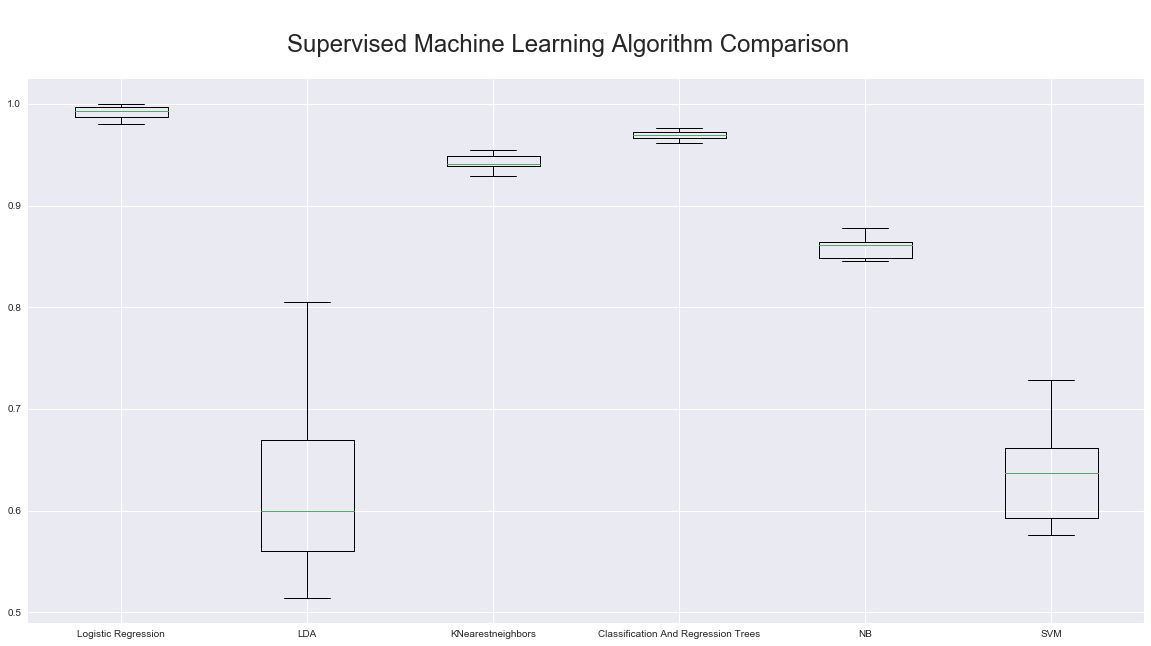

In [68]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(20,10))
fig.suptitle('\nSupervised Machine Learning Algorithm Comparison', size =24)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Random Forest model
- oob_score(out of bag)=True shows model performance with or without using Cross-Validation
- Generally the target follows a certain distribution and few observations, then using CV will not give much improvement.

In [97]:
RandomForestmodel = RandomForestClassifier(n_estimators = 100, oob_score = True, n_jobs = 1,random_state =1)

In [98]:
RandomForestmodel.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

In [99]:
RandomForestmodel_2 = RandomForestClassifier(n_estimators = 100,oob_score = True, n_jobs = -1, random_state=1)

In [100]:
RandomForestmodel_2.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

## another Random forest Model

In [101]:
RF_model =  RandomForestRegressor(n_estimators = 100 , oob_score =True, random_state = 42)

In [102]:
RF_model.fit(X,y).feature_importances_

array([  5.32733481e-02,   5.82420115e-02,   5.68543669e-03,
         5.42954668e-02,   4.81342570e-04,   5.59988183e-02,
         1.16570321e-03,   7.89451257e-04,   7.51200632e-01,
         4.06927589e-03,   2.47228557e-03,   6.82354293e-03,
         5.16167175e-04,   4.98651749e-03])

In [103]:
RF_model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [104]:
RF_model.feature_importances_

array([  5.32733481e-02,   5.82420115e-02,   5.68543669e-03,
         5.42954668e-02,   4.81342570e-04,   5.59988183e-02,
         1.16570321e-03,   7.89451257e-04,   7.51200632e-01,
         4.06927589e-03,   2.47228557e-03,   6.82354293e-03,
         5.16167175e-04,   4.98651749e-03])

In [105]:
print "AUC - ROC : ", roc_auc_score(y, RF_model.oob_prediction_)

AUC - ROC :  0.99880608417


In [106]:
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

/Users/jg/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jg/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


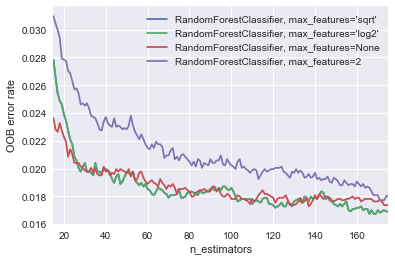

In [107]:
# this cell takes about 90 seconds to run
RANDOM_STATE = 42
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=2",
        RandomForestClassifier(warm_start=True, max_features=2,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

#### Twice the estimators
and multiple leaf options using the regressor

In [108]:
%time  
%timeit
sample_leaf_options = [1,5,10,50,100,200,500]
for leaf_size in sample_leaf_options :
    model_RF_loop = RandomForestRegressor(
        n_estimators = 200, 
        oob_score = True, 
        n_jobs = -1,
        random_state = 42,
        max_features = "auto", 
        min_samples_leaf = leaf_size)
    model_RF_loop.fit(X, y)
    print "Leaf Size:", leaf_size, "    AUC - ROC : ", roc_auc_score(y, model_RF_loop.oob_prediction_ )

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 17.2 µs
Leaf Size: 1     AUC - ROC :  0.998862990345
Leaf Size: 5     AUC - ROC :  0.998787198568
Leaf Size: 10     AUC - ROC :  0.99849487073
Leaf Size: 50     AUC - ROC :  0.996633707966
Leaf Size: 100     AUC - ROC :  0.995006188027
Leaf Size: 200     AUC - ROC :  0.991450208742
Leaf Size: 500     AUC - ROC :  0.988021341528


Group the data in ways that shows insights

In [109]:
airport_grouping = data.iloc[:, [0, 1, 2, 3, 4,5,6,7]].groupby(by=['airport_name', 'carrier', 'year', 'month'])

In [110]:
airport_grouping.sum()

arr_flights  \
airport_name                           carrier year month                
Aberdeen, SD: Aberdeen Regional        OO      2016 1             62.0   
                                                    2             58.0   
                                                    3             62.0   
                                                    4             60.0   
                                                    5             62.0   
                                                    6             60.0   
                                                    7             62.0   
                                                    8             62.0   
                                                    9             60.0   
                                                    10            69.0   
                                                    11            65.0   
Abilene, TX: Abilene Regional          EV      2016 6              4.0   
                                                    7             23.0   
                                                    8             27.0   
                                                    9             26.0   
                                                    10            29.0   
                                                    11            25.0   
Adak Island, AK: Adak                  AS      2016 1              9.0   
                                                    2              8.0   
                                                    3              9.0   
                                                    4              8.0   
                                                    5              9.0   
                                                    6              9.0   
                                                    7              9.0   
                                                    8              8.0   
                                                    9              9.0   
                                                    10             9.0   
                                                    11             8.0   
Aguadilla, PR: Rafael Hernandez        B6      2016 1            123.0   
                                                    2             67.0   
...                                                                ...   
Wrangell, AK: Wrangell Airport         AS      2016 4             60.0   
                                                    5             62.0   
                                                    6             60.0   
                                                    7             62.0   
                                                    8             62.0   
                                                    9             60.0   
                                                    10            62.0   
                                                    11            58.0   
Yakutat, AK: Yakutat Airport           AS      2016 1             60.0   
                                                    2             58.0   
                                                    3             62.0   
                                                    4             60.0   
                                                    5             61.0   
                                                    6             60.0   
                                                    7             61.0   
                                                    8             62.0   
                                                    9             60.0   
                                                    10            62.0   
                                                    11            58.0   
Yuma, AZ: Yuma MCAS/Yuma International OO      2016 1            177.0   
                                                    2            165.0   
                                                    3          

In [111]:
airport_grouping.mean().head()

arr_flights  carrier_ct
airport_name                    carrier year month                         
Aberdeen, SD: Aberdeen Regional OO      2016 1             62.0        0.00
                                             2             58.0        5.63
                                             3             62.0        2.23
                                             4             60.0        1.00
                                             5             62.0        1.00

In [112]:
airport_grouping.median().head()

arr_flights  carrier_ct
airport_name                    carrier year month                         
Aberdeen, SD: Aberdeen Regional OO      2016 1             62.0        0.00
                                             2             58.0        5.63
                                             3             62.0        2.23
                                             4             60.0        1.00
                                             5             62.0        1.00

In [113]:
# this cell takes about a minute to run
airport_grouping.describe().head()

arr_flights            \
                                                         count  mean std   
airport_name                    carrier year month                         
Aberdeen, SD: Aberdeen Regional OO      2016 1             1.0  62.0 NaN   
                                             2             1.0  58.0 NaN   
                                             3             1.0  62.0 NaN   
                                             4             1.0  60.0 NaN   
                                             5             1.0  62.0 NaN   

                                                                            \
                                                     min   25%   50%   75%   
airport_name                    carrier year month                           
Aberdeen, SD: Aberdeen Regional OO      2016 1      62.0  62.0  62.0  62.0   
                                             2      58.0  58.0  58.0  58.0   
                                             3      62.0  62.0  62.0  62.0   
                                             4      60.0  60.0  60.0  60.0   
                                             5      62.0  62.0  62.0  62.0   

                                                         carrier_ct            \
                                                     max      count  mean std   
airport_name                    carrier year month                              
Aberdeen, SD: Aberdeen Regional OO      2016 1      62.0        1.0  0.00 NaN   
                                             2      58.0        1.0  5.63 NaN   
                                             3      62.0        1.0  2.23 NaN   
                                             4      60.0        1.0  1.00 NaN   
                                             5      62.0        1.0  1.00 NaN   

                                                                            \
                                                     min   25%   50%   75%   
airport_name                    carrier year month                           
Aberdeen, SD: Aberdeen Regional OO      2016 1      0.00  0.00  0.00  0.00   
                                             2      5.63  5.63  5.63  5.63   
                                             3      2.23  2.23  2.23  2.23   
                                             4      1.00  1.00  1.00  1.00   
                                             5      1.00  1.00  1.00  1.00   

                                                          
                                                     max  
airport_name                    carrier year month        
Aberdeen, SD: Aberdeen Regional OO      2016 1      0.00  
                                             2      5.63  
                                             3      2.23  
                                             4      1.00  
                                             5      1.00

It would be useful to see the data grouped by airport and count of late arrivals

In [114]:
denver = data.airport == 'DEN'
denver.head()

0    False
1    False
2    False
3    False
4    False
Name: airport, dtype: bool

In [115]:
carrier_grouping = data.iloc[:, [0, 1, 2, 3, 4,5,6,7, 8]].groupby(by=['carrier_name', 'year', 'month'])

In [116]:
carrier_grouping.sum()

arr_flights  carrier_ct  weather_ct
carrier_name           year month                                     
Alaska Airlines Inc.   2016 1          14205.0      410.72       65.10
                            2          13399.0      390.42       27.14
                            3          14781.0      449.26       22.61
                            4          14662.0      382.61       11.59
                            5          15385.0      404.49       14.30
                            6          15730.0      458.06       35.03
                            7          16256.0      466.95       26.67
                            8          16455.0      460.72       39.29
                            9          13858.0      319.39       24.51
                            10         14088.0      342.50       37.36
                            11         13946.0      417.04       23.06
American Airlines Inc. 2016 1          75580.0     4397.83      374.40
                            2          71440.0     3437.04      327.03
                            3          79119.0     4301.65      412.13
                            4          74859.0     3557.23      315.71
                            5          78678.0     4246.90      699.27
                            6          79648.0     6277.23      786.37
                            7          81678.0     6565.57      953.90
                            8          80241.0     6113.78      836.34
                            9          72459.0     3634.08      487.08
                            10         75171.0     3433.82       86.16
                            11         71819.0     3032.41      112.26
Delta Air Lines Inc.   2016 1          69711.0     2919.70      549.45
                            2          67771.0     2669.67      461.35
                            3          78210.0     3034.07      350.46
                            4          76607.0     2746.23      160.54
                            5          80556.0     3342.27      282.82
                            6          81517.0     4103.74      673.44
                            7          83677.0     4699.28      890.76
                            8          84540.0     5936.10      476.31
...                                        ...         ...         ...
Spirit Air Lines       2016 4          11281.0      644.27       47.50
                            5          11992.0      623.45       71.68
                            6          11605.0      714.68       55.43
                            7          11995.0      216.06       17.02
                            8          11992.0      303.06       53.37
                            9          11151.0       36.98        5.39
                            10         11503.0      186.70        5.65
                            11         11607.0      324.47       18.37
United Air Lines Inc.  2016 1          39761.0     2064.86      294.64
                            2          38944.0     1553.06      284.70
                            3          44250.0     2330.40      265.09
                            4          43281.0     1735.66      160.74
                            5          45914.0     2204.20      230.11
                            6          46424.0     2865.74      380.90
                            7          48049.0     3152.23      571.45
                            8          49758.0     3083.73      431.36
                            9          46935.0     2259.40      236.23
                            10         49951.0     2518.95       65.94
                            11         46082.0     1922.49      122.15
Virgin America         2016 1           5384.0      237.80       71.20
                            2           4941.0      161.30       75.00
                            3           5635.0      266.02       71.94
                            4           5644.0      237.04       99.94
                            5           5847.0      280.78 

In [117]:
# # this little for loop helps find the column numbers when slicing with .iloc
# for i, x in enumerate(data.columns):
#     print("%d. %s"%(i, x))

In [118]:
late_count = data.iloc[:, [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 7]]
late_count.corr()

,arr_flights,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,target_X,carrier_ct
arr_flights,1.000000,0.768739,0.804379,0.512487,0.881786,0.565827,0.636067,0.875205,0.876582,0.742316,0.697623,0.457597,0.852771,0.283758,0.918256
weather_ct,0.768739,1.000000,0.747240,0.497817,0.789935,0.539500,0.710763,0.821846,0.755200,0.954521,0.693923,0.451133,0.798067,0.243806,0.819565
nas_ct,0.804379,0.747240,1.000000,0.527607,0.810437,0.580871,0.626720,0.901002,0.771117,0.727642,0.949171,0.491155,0.830760,0.277520,0.831446
security_ct,0.512487,0.497817,0.527607,1.000000,0.563590,0.368564,0.405597,0.525674,0.475086,0.476423,0.435350,0.838333,0.537822,0.190799,0.575996
late_aircraft_ct,0.881786,0.789935,0.810437,0.563590,1.000000,0.626644,0.675512,0.924192,0.854865,0.764240,0.729300,0.527007,0.969846,0.294210,0.936909
arr_cancelled,0.565827,0.539500,0.580871,0.368564,0.626644,1.000000,0.480179,0.659195,0.609488,0.550791,0.587824,0.323593,0.642849,0.192698,0.620186
arr_diverted,0.636067,0.710763,0.626720,0.405597,0.675512,0.480179,1.000000,0.711480,0.647781,0.721620,0.613622,0.372053,0.700735,0.166036,0.678039
arr_delay,0.875205,0.821846,0.901002,0.525674,0.924192,0.659195,0.711480,1.000000,0.945608,0.819009,0.874484,0.510864,0.971350,0.278043,0.942848
carrier_delay,0.876582,0.755200,0.771117,0.475086,0.854865,0.609488,0.647781,0.945608,1.000000,0.757641,0.713888,0.464096,0.909957,0.257489,0.931457
weather_delay,0.742316,0.954521,0.727642,0.476423,0.764240,0.550791,0.721620,0.819009,0.757641,1.000000,0.687027,0.432981,0.787836,0.215498,0.796313


In [119]:
# Denver only
carrier_grouping = data.iloc[:, [2, 3, 4,5,6,7, 20]].groupby(by=['airport', 'carrier'])
carr_x = carrier_grouping.mean()
denver_by_carrier = carr_x[271:281]
denver_by_carrier

arr_flights  carrier_ct  target_X
airport carrier                                   
DEN     AA        876.636364   65.354545  1.000000
        AS        141.181818    6.504545  0.545455
        B6         92.454545    8.475455  0.818182
        DL        751.363636   38.898182  1.000000
        F9       1887.545455   69.364545  1.000000
        NK        372.727273   11.340000  1.000000
        OO       4347.000000  128.551818  1.000000
        UA       4914.909091  188.897273  1.000000
        VX         82.444444    2.643333  0.555556
        WN       5463.727273  224.510000  1.000000

In [120]:
denver_by_carrier.index.values

array([('DEN', 'AA'), ('DEN', 'AS'), ('DEN', 'B6'), ('DEN', 'DL'),
       ('DEN', 'F9'), ('DEN', 'NK'), ('DEN', 'OO'), ('DEN', 'UA'),
       ('DEN', 'VX'), ('DEN', 'WN')], dtype=object)

In [126]:
air_port, carrier_ = zip(*denver_by_carrier.index.values)
print (air_port),
print "\n"
print (carrier_)

('DEN', 'DEN', 'DEN', 'DEN', 'DEN', 'DEN', 'DEN', 'DEN', 'DEN', 'DEN') 

('AA', 'AS', 'B6', 'DL', 'F9', 'NK', 'OO', 'UA', 'VX', 'WN')
